### Нейронная сеть для классификации

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [2]:
# загружаем данные из csv файла
df = pd.read_csv(r"C:\Users\Admin\Jupyter\zakupki\dataset_nlp_process.csv",  on_bad_lines='skip', low_memory=False, sep=';') 
df['subject']  = df['subject'].astype('string')
df['cost']  = df['cost'].astype('int64')
df['okpd_code']  = df['okpd_code'].astype('string')
df['okpd_code']  = df['okpd_code'].apply(lambda x: x.strip())
df['price_per_day'] = (df['cost'] / df['execution_period']).astype('int64')
df = df.drop('data', axis=1)
df.dtypes

id                           int64
subject             string[python]
okpd_code                   object
cost                         int64
execution_period             int64
data_final                  object
price_per_day                int64
dtype: object

In [3]:
#Делаем разбивку по группам на основании номеров ОКПД-2
import re 

def match(templ, value):
    try:
      return re.search(f'^{templ}.', value) 
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return False
    
def get_group(value):    
    if (match('41', value) or match('42', value) or match('43', value)) and  value not in ('43.9', '42.9', '42.2', '43.2', '41.1', '71.1', '43.2'):  
        return 'Строительно-монтажные работы'
    elif value in ('41.1', '71.1'):  
        return 'Проектно-изыскательские работы'
    elif value in ('43.2'):  
        return 'Подключение коммуникаций'
    elif value in ('43.9', '42.9', '42.2'):  
        return 'Строительный надзор'
    else:
        return 'Прочие'

df['group'] = df['okpd_code'].apply(lambda x: get_group(x))
df.head()

,id,subject,okpd_code,cost,execution_period,data_final,price_per_day,group
0,27206446,"приобретение нежилого здания, в целях осуществ...",41.2,18061000,1,"['приобретен', 'нежил', 'здан', 'цел', 'осущес...",18061000,Строительно-монтажные работы
1,18675346,Выполнение работ по ремонту подъездов по адрес...,41.2,1740653,1,"['выполнен', 'работ', 'ремонт', 'подъезд', 'ад...",1740653,Строительно-монтажные работы
2,22454818,Содержание автомобильных дорог местного значен...,42.1,35528286,1,"['содержан', 'автомобильн', 'дорог', 'местн', ...",35528286,Строительно-монтажные работы
3,21437940,"Ремонт автомобильной дороги,ул.2-я Пятилетка (...",42.1,976423,1,"['ремонт', 'автомобильн', 'дорог', 'пятилетк',...",976423,Строительно-монтажные работы
4,4962120,Выполнение работ по ремонту коридора в здании ...,43.3,351157,1,"['выполнен', 'работ', 'ремонт', 'коридор', 'зд...",351157,Строительно-монтажные работы


In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

tfidf = TfidfVectorizer(max_features=700, min_df=5, max_df=0.7)

X = df['data_final']
tfidf_X = tfidf.fit_transform(X).toarray()
tfidf_X.shape

(949747, 700)

In [6]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder = OneHotEncoder()
data_new = onehotencoder.fit_transform(df['group'].values.astype('U').reshape(-1, 1))
columns = np.char.strip(onehotencoder.categories_[0].astype('U'))
df_one_hot_codes = pd.DataFrame(data_new.toarray(), columns=columns).astype('int64')
df_one_hot_codes.head(4)

,Подключение коммуникаций,Проектно-изыскательские работы,Строительно-монтажные работы,Строительный надзор
0,0,0,1,0
1,0,0,1,0
2,0,0,1,0
3,0,0,1,0


In [21]:
y2 = np.array(df_one_hot_codes)

In [22]:
y2

array([[0, 0, 1, 0],
       [0, 0, 1, 0],
       [0, 0, 1, 0],
       ...,
       [0, 1, 0, 0],
       [0, 1, 0, 0],
       [0, 1, 0, 0]], dtype=int64)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_X, df_one_hot_codes, test_size=0.3)
print(X_train.shape, X_test.shape)

(664822, 700) (284925, 700)


In [25]:
print(y_train.shape, y_test.shape)

(664822, 4) (284925, 4)


In [26]:
import tensorflow as tf
tf.random.set_seed(1)
model_nn = tf.keras.models.Sequential([
tf.keras.layers.InputLayer(shape=(700,)),
tf.keras.layers.Dense(700, activation='sigmoid',name='fc1'),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(700, activation='sigmoid',name='fc3'),
# tf.keras.layers.BatchNormalization(),
tf.keras.layers.Dense(4, name='fc4', activation='softmax')])
# Компиляция модели
model_nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Вывод сводки
model_nn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                          │ (None, 700)                 │         490,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 700)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 700)                 │         490,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc4 (Dense)                          │ (None, 4)                   │           2,804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 984,204 (3.75 MB)

 Trainable params: 984,204 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# Функция компиляции и обучения модели нейронной сети
def compile_train_model(model,
                        x_train,
                        y_train,
                        x_val,
                        y_val,
                        optimizer='adam',
                        epochs=50,
                        batch_size=128,
                        figsize=(20, 5)):

    # Компиляция модели
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # Вывод сводки
    model.summary()

    # Обучение модели с заданными параметрами
    history = model.fit(x_train, y_train,
                        epochs=epochs,
                        batch_size=batch_size,
                        validation_data=(x_val, y_val))

    # Вывод графиков точности и ошибки
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('График процесса обучения модели')
    ax1.plot(history.history['accuracy'],
               label='Доля верных ответов на обучающем наборе')
    ax1.plot(history.history['val_accuracy'],
               label='Доля верных ответов на проверочном наборе')
    ax1.xaxis.get_major_locator().set_params(integer=True)#Целочисленные координаты оси абсцисс установлены
    ax1.set_xlabel('Эпоха обучения')
    ax1.set_ylabel('Доля верных ответов')
    ax1.legend()

    ax2.plot(history.history['loss'],
               label='Ошибка на обучающем наборе')
    ax2.plot(history.history['val_loss'],
               label='Ошибка на проверочном наборе')
    ax2.xaxis.get_major_locator().set_params(integer=True)
    ax2.set_xlabel('Эпоха обучения')
    ax2.set_ylabel('Ошибка')
    ax2.legend()
    plt.show()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ fc1 (Dense)                          │ (None, 700)                 │         490,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 700)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc3 (Dense)                          │ (None, 700)                 │         490,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc4 (Dense)                          │ (None, 4)                   │           2,804 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 984,204 (3.75 MB)

 Trainable params: 984,204 (3.75 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 87s 6ms/step - accuracy: 0.7313 - loss: 0.6888 - val_accuracy: 0.8026 - val_loss: 0.5262
Epoch 2/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.7998 - loss: 0.5321 - val_accuracy: 0.8053 - val_loss: 0.5108
Epoch 3/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.8058 - loss: 0.5131 - val_accuracy: 0.8077 - val_loss: 0.5008
Epoch 4/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.8084 - loss: 0.5025 - val_accuracy: 0.8099 - val_loss: 0.4926
Epoch 5/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 86s 6ms/step - accuracy: 0.8111 - loss: 0.4936 - val_accuracy: 0.8126 - val_loss: 0.4855
Epoch 6/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.8141 - loss: 0.4858 - val_accuracy: 0.8145 - val_loss: 0.4809
Epoch 7/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 88s 7ms/step - accuracy: 0.8174 - loss: 0.4785 - val_accuracy: 0.8167 - val_loss: 0.4752
Epoch 8/15
13297/13297 ━━━━━━━━━━━━━━━━━━━━ 90s 7ms/step - accuracy: 

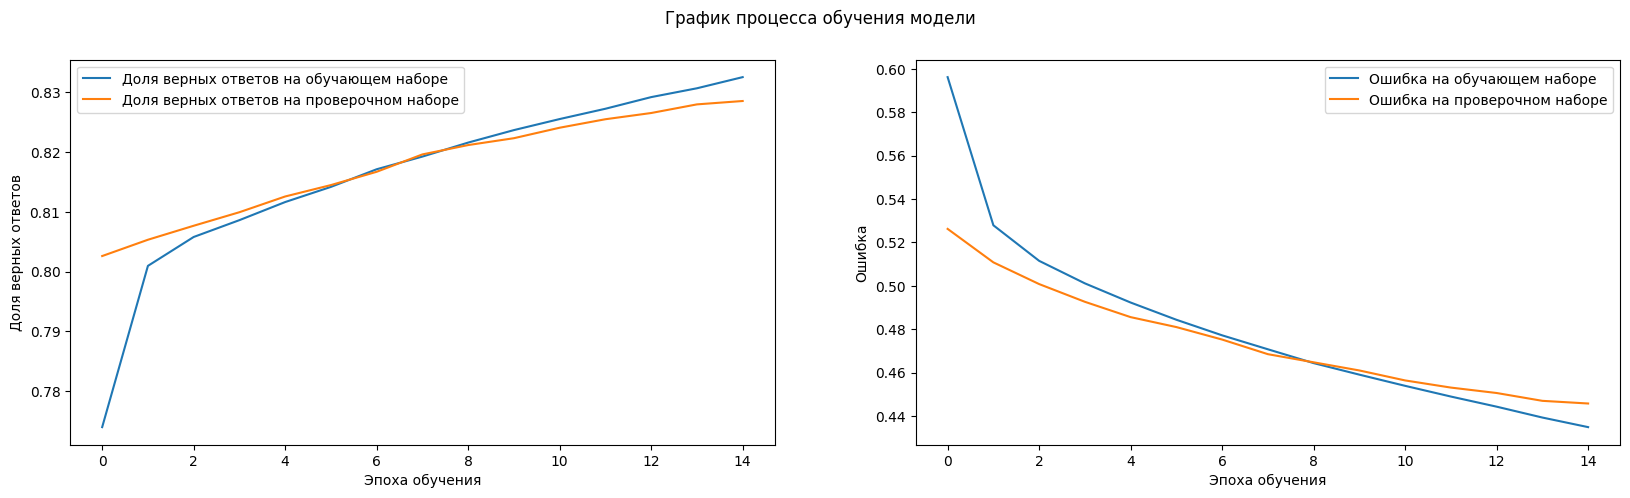

In [27]:
compile_train_model(model=model_nn, x_train=X_train, y_train=y_train, 
                    x_val=X_test, y_val=y_test,
                    epochs=15,
                    batch_size=50,
                    figsize=(20, 5))

In [31]:
model_nn.save('model_nn.keras')